<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Regression Challenge
Notebook II

--- 
#### Linear Regression Modeling


Notebook II to IV showcase the modeling process for this project: Started from selecting most relevant features. Then a null model was established as a baseline, follwed by fitting a simple ols model. More features and engineering were added along the way as well as more complex tools such as regularization and log transformation to fine tune the model for a best result. There are 7 models included in three notebooks.


This notebook contains the following content:

- [Feature Selection](#Feature-Selection)
- [Baseline Model](#Model-1---Baseline-Model)
- [OLS Model](#Model-2---OLS-Model)
- [OLS Model with Feature Intersection](#Model-3---OLS-Model-Improved)
---

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import pickle

In [2]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

train = pd.read_csv('../datasets/train_clean.csv')
test = pd.read_csv('../datasets/test_clean.csv')

### Feature Selection

Even after the data cleaning, there are still 64 features in the training dataset. In order to have a good model with effective features, I decide to use those with the strongest corrlation (positive and negative) with sale price.

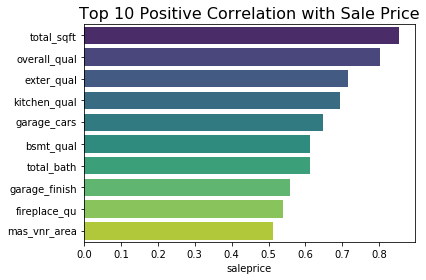

In [3]:
pos_corr = train.corr()[['saleprice']].sort_values('saleprice', ascending = False)[:11].drop('saleprice')
sns.barplot(x = pos_corr['saleprice'], y = pos_corr.index, orient = 'h', palette = 'viridis')
plt.title('Top 10 Positive Correlation with Sale Price', fontsize = 16)
plt.tight_layout()
plt.savefig('../charts/top10_pos_corr.png');

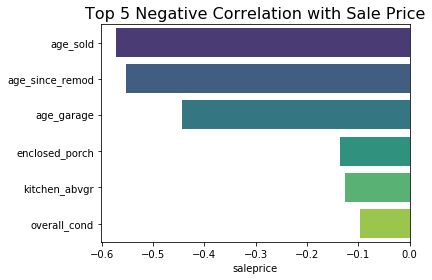

In [4]:
neg_corr = train.corr()[['saleprice']].sort_values('saleprice')[:6]
sns.barplot(x = neg_corr['saleprice'], y = neg_corr.index, orient = 'h', palette = 'viridis')
plt.title('Top 5 Negative Correlation with Sale Price', fontsize = 16)
# inspired by Hov!
plt.tight_layout()
plt.savefig('../charts/top5_neg_corr.png');

From the above two charts, I have selected my initial features: all top 10 positive correlators and age_sold and age_since_remod in negative correlators.

### Model 1 - Baseline Model
First I'm building a baseline model. I will be using the mean of the sale price in the training data to predict all the sale price in the testing data. For this model, doesn't really matter what features I pick. The prediction will always be the same.

In [5]:
X = train.drop('saleprice', axis =1)
y = train['saleprice']

In [6]:
# train-test-split just to manual calculate the RMSE
X_test, X_train, y_test, y_train = train_test_split(X, y, random_state = 42)

In [7]:
mse = 0
for i in y_train:
    residual = i - y.mean()
    mse += residual ** 2
rmse = mse ** 0.5

print(f'RMSE is: {rmse}')

RMSE is: 1800901.165397851


In [8]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['SalePrice'] = train['saleprice'].mean()
submission.to_csv('../result/submission_null.csv', index = False)

As you can see the local RMSE is very high. The result has a Kaggle RMSE of 83323.21.

### Model 2 - OLS Model
My first linear regression model will be using features that I mentioned in the previous feature selection part. The model has not gone through any advanced engineering and is the least complex of all. However as mentioned, all the features included have a relatively high correlation with sale price.

In [9]:
# define features, X, and y
features = ['total_sqft',
           'total_bath',
           'garage_finish',
           'mas_vnr_area',
           'overall_qual',
           'exter_qual',
           'kitchen_qual',
           'bsmt_qual',
           'fireplace_qu',
           'garage_cars',
           'age_sold',
           'age_since_remod']

X = train[features]
y = train['saleprice']
features_train = X.columns

In [10]:
# train-test-split, will be using the default 3:1 since we have enough data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# instantiate the linear regression model
lr = LinearRegression()

# fit the model to train data from the train_test_split
lr.fit(X_train, y_train)

# evaluate the model using R2
print(f'Train R2 score is: {lr.score(X_train, y_train)}')
print(f'Test R2 score is: {lr.score(X_test, y_test)}')

# evaluate with RMSE
pred = lr.predict(X_test)
rmse = (metrics.mean_squared_error(y_test, pred)) ** 0.5
print(f'RMSE is: {rmse}')

Train R2 score is: 0.8510507379487142
Test R2 score is: 0.8687868759807058
RMSE is: 28801.812478710206


This RMSE score is so much better than the baseline. It also has a close R<sup>2</sup> score between train and test data around 0.85 to 0.87, which means that this model fit around 85% - 87% of the data. Not too bad but not perfect either. The higher test score result also indicates a possible lower variance model, which means we might need to optimize a more complex model to better fit. However since it's better fit now, I'm going to go ahead and predict the sale price for the actual test data.

In [11]:
# format per Kaggle requirement 
X_1 = test[features]
features_test = X_1.columns
pred_saleprice = lr.predict(X_1)

In [12]:
# export result to CSV file
submission = pd.DataFrame()
submission['id'] = test['id']
submission['SalePrice'] = pred_saleprice
submission.to_csv('../result/submission_1.csv', index = False)

This submission on Kaggle returns a RMSE of 31964.12697.

### Model 3 - OLS Model Improved

For this model, I aim to create improve with more advanced feature engineering such as interaction. I decide to intersect total square feet and overall quality features, as both of them are critical factors of a house sale price. I also added in some categorical features which I believe to be important to sale price as discussed in the data cleaning stage. These features include: neighborhood, year sold and ms subclass. Also to be more consistant with the scope, I added total bedroom since it's also a common factor.

In [13]:
# intersecting the features
train['total_sqft * overall_qual'] = train['total_sqft'] * train['overall_qual']
test['total_sqft * overall_qual'] = test['total_sqft'] * test['overall_qual']

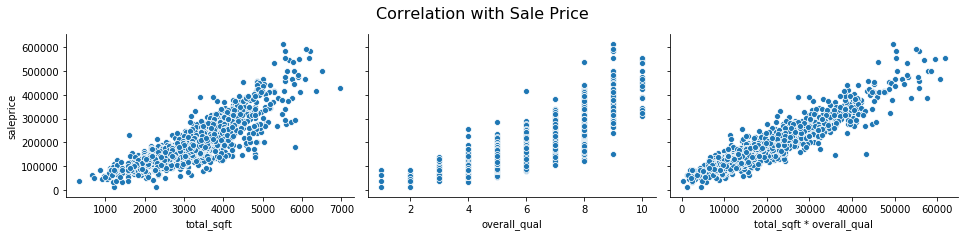

In [14]:
sns.pairplot(train, y_vars = 'saleprice', 
             x_vars = ['total_sqft', 'overall_qual', 'total_sqft * overall_qual'], 
             height = 3, 
             aspect = 1.5)
plt.suptitle('Correlation with Sale Price', fontsize = 16, y = 1.08)
plt.tight_layout()
plt.savefig('../charts/intersection.png');

As shown above the correlation definitely becomes more linear and strongly correlated, which makes me certain to move forward with this engineered feature.

In [15]:
df = train.copy()
df_test = test.copy()

In [16]:
features = ['total_sqft',
            'total_bath',
            'total_bedroom',
            'mas_vnr_area',
            'neighborhood',
            'overall_qual',
            'exter_qual',
            'kitchen_qual',
            'bsmt_qual',
            'fireplace_qu',
            'garage_cars',
            'garage_finish',
            'age_sold',
            'age_since_remod',
            'yr_sold',
            'total_sqft * overall_qual',
            'ms_subclass']

X = df[features]

# dummify categorical features
X = pd.get_dummies(data = X, columns = ['neighborhood','yr_sold', 'ms_subclass'], drop_first = True)
y = df['saleprice']

features_train = X.columns

In [17]:
# train-test-split, will be using the default 3:1 since we have enough data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# instantiate the linear regression model
lr = LinearRegression()

# fit the model to train data from the train_test_split
lr.fit(X_train, y_train)

# evaluate the model using R2
print(f'Train R2 score is: {lr.score(X_train, y_train)}')
print(f'Test R2 score is: {lr.score(X_test, y_test)}')

# evaluate with RMSE
pred = lr.predict(X_test)
rmse = (metrics.mean_squared_error(y_test, pred)) ** 0.5
print(f'RMSE is: {rmse}')

Train R2 score is: 0.9106225155573133
Test R2 score is: 0.9250739227482012
RMSE is: 21764.449086767963


The RMSE has dropped by over 8,000 for this model, indicating that the intersection is significantly improving the model. It also produced 91% R<sup>2</sup> score for training data and 92.5% for the test.

In [18]:
# dummify real testing data
X_1 = test[features]
X_1 = pd.get_dummies(data = X_1, columns = ['neighborhood', 'yr_sold', 'ms_subclass'], drop_first = True)
features_test = X_1.columns

In [19]:
# since there are dummification, check if the training and testing shape matches
print(f'Test data shape: {X_1.shape}')
print(f'Train data shape: {X.shape}')

Test data shape: (878, 57)
Train data shape: (2049, 60)


The columns numbers of train and test data mismatch, a result that test data does not have some of the dummy features. So I'm identifying what columns are and adding them to the test data in the same order as the ones in train data.

In [20]:
# credit to James Hampton who gave me this great idea!
train_only = set(features_train) - set(features_test)

for missing_col in train_only:
    X_1[missing_col] = 0

X_1 = X_1[X.columns]

In [21]:
pred_saleprice = lr.predict(X_1)

In [22]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['SalePrice'] = pred_saleprice
submission.to_csv('../result/submission_2.csv', index = False)

This submission has a Kaggle RMSE of 24883.35478

### Pickling

In [26]:
# inspired by Charlie's lecture
import pickle
import os
os.mkdir('../assets/')

In [27]:
file_name = '../assets/ols_model_improved.pkl'

pickle.dump(lr, open(file_name, 'wb'))